# Jupyter Notebook Script for Predicting Quantities

## Import Libraries

In [1]:
# Oudere libraries importeren
import pandas as pd
import numpy as np
import pyodbc
import sqlite3

# Nieuwe libraries importeren
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from db_utils.db_utils import create_connection, run_query

## Load Data


Hieronder wordt aangenomen dat de gegevens al zijn ingeladen en verwerkt zoals nodig
Indien nodig kunnen we de code toevoegen voor het inlezen en voorbewerken van de gegevens

In [2]:
merged_order_df = run_query("SELECT * FROM OrderData", 'test')

c:\Users\lfatm\Documents\School\deds_proj_groep1\db_utils\db_utils.py:37: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


## Data Preprocessing


Definieer de kenmerken (features) en de doelvariabelen (targets)

In [3]:
features = ['prod_id', 'ReceivedQty', 'RejectedQty', 'StockedQty', 'prod_id', 'UnitPrice_y','LineTotal', 'ReceivedQty', 'RejectedQty', 'StockedQty', 'order_date', 'region', 'ship_date', 'ModifiedDate']
target_quantity = 'quantity'

Vanwege het feit dat we bezig zijn met het bouwen en trainen van een lineaire regressie model, betekent het dat alle variabelen, numeriek moeten zijn. Vandaar dat we de niet-numerieke variabelen zullen converteren met behulp van one-hot encoding

In [4]:
columns_to_drop = ['order_date', 'region', 'ship_date', 'ModifiedDate']
merged_order_df = merged_order_df.drop(columns=columns_to_drop)

## Model Building


In [5]:
X = merged_order_df.drop(target_quantity, axis=1)
Y = merged_order_df.loc[:, target_quantity]

In deze stap splitsen we de gegevens in trainings- en testsets. Dit doen we om het model te trainen op een subset van de gegevens (de trainingsset) en vervolgens de prestaties van het model te evalueren op een andere subset (de testset). Hierdoor kunnen we beoordelen hoe goed het model generaliseert naar nieuwe, ongeziene gegevens. We gebruiken een testgrootte van 20% en stellen een random_state in op 42 om reproduceerbaarheid te garanderen.

In [6]:
## Opsplitsen van gegevens in trainings- en testsets
X_train, X_test, y_train, y_test = train_test_split(
        X, 
        Y, 
        test_size=0.2, 
        random_state=42
    )

We initialiseren en trainen een lineair regressiemodel om de variabele 'quantity' te voorspellen. Het model wordt getraind met behulp van de trainingsgegevens (X_train en y_train).

In [7]:
# Model initialisatie en training voor 'quantity'
quantity_model = linear_model.LinearRegression()
quantity_model = LinearRegression().fit(X_train, y_train)

Na deze stappen is het model klaar om voorspellingen te doen en kunnen we de prestaties ervan evalueren met de testset.

### Voorspelde vs Werkelijke waarden

In [8]:
# Voorspellingen maken
predictions = quantity_model.predict(X_test)

# Bereken de verschillen en sla ze op in een lijst
differences = [(abs(pred - actual), pred, actual) for pred, actual in zip(predictions, y_test)]

# Sorteer de lijst op basis van het verschil
differences.sort(key=lambda x: x[0])

# Print de gesorteerde voorspelde en werkelijke waarden
print(f'{"Index":<5} {"Verschil":<10} {"Voorspelde waarde":<20} {"Werkelijke waarde":<20}')
print('-' * 60)
for idx, (diff, pred, actual) in enumerate(differences):
    print(f'{idx:<5} {diff:<10.2f} {pred:<20.2f} {actual:<20}')


Index Verschil   Voorspelde waarde    Werkelijke waarde   
------------------------------------------------------------
0     0.02       23.98                24                  
1     0.08       23.92                24                  
2     0.33       24.33                24                  
3     0.43       23.57                24                  
4     0.48       24.48                24                  
5     0.49       23.51                24                  
6     0.54       24.54                24                  
7     0.57       23.43                24                  
8     0.58       23.42                24                  
9     0.77       24.77                24                  
10    0.78       23.22                24                  
11    0.78       23.22                24                  
12    0.78       24.78                24                  
13    0.82       23.18                24                  
14    0.88       24.88                24              

Maak een DataFrame met voorspelde en werkelijke waarden

In [9]:
predictions_df = pd.DataFrame({'Predicted': predictions, 'Actual': y_test})
predictions_df = predictions_df.rename(columns={0: 'Predicted', 'quantity': 'Actual'})
predictions_df.head()

,Predicted,Actual
309,28.644672,48
1041,31.808898,60
381,31.430535,36
497,21.531805,24
551,19.574046,12


### Plotten van het regressiemodel

Maak een scatter plot van werkelijke vs. voorspelde waarden

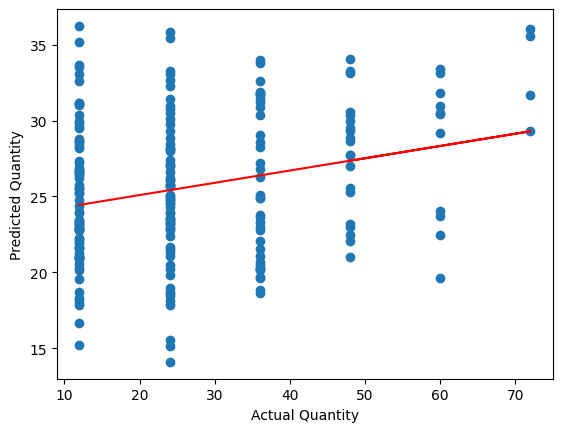

In [10]:
plt.scatter(y_test, predictions)
plt.xlabel('Actual Quantity')
plt.ylabel('Predicted Quantity')

m, b = np.polyfit(y_test, predictions, 1)
plt.plot(y_test, m*y_test + b, color='red')

plt.show()


Bereken de gemiddelde kwadratische fout (Mean Squared Error)

In [11]:
mean_squared_error(y_test, predictions)

215.1805596780541

Bereken de gemiddelde absolute fout (Mean Absolute Error)

In [12]:
mean_absolute_error(y_test, predictions)

11.745807443834861